In [ ]:
# Initialize the environment
using Pkg
Pkg.activate(".")
Pkg.instantiate()
ENV["DATADEPS_ALWAYS_ACCEPT"] = true # accept the download of the MNIST dataset
SHOW_PROGRESS_BAR = true # turn off progress bars

# Quantum Reservoir Computing for Time Series Prediction Demo

In this notebook we will show you how to train a time-series prediction using quantum reservoir computing (QRC) in Julia programming language. The general idea is that the chaotic, non-linear dynamics of quantum systems can be used to create a non-linear mapping from a low-dimensional space (which will be the time-windows extracted from the time-series data) to a high dimensional space. In order to construct the mapping, we first ensure that information from the time-window will directly impact the dynamics of the quantum system. Then, we measure certain properties (in this case, spin expectations and correlations) over time. These measurements form the output of the mapping.   

This demo provides a toy model that does not require access to a quantum computer. It uses classical, numerical simulations of a quantum system with 10 qubits. The classical simulation makes use of the package Bloqade, which is designed for numerical simulations of neutral-atom architectures. 

Neutral atom architectures provide access to several variational parameters. In this demo, we map the time-window features to the local detuning terms in the Rydberg Hamiltonian as well as time-dependence of global detuning. We then measure the quantum system and train the classical model which maps the quantum readout from the measurement to the desired prediction. As all training process is in the classical part (excuted on a classical computer), we expect the training is substantially shorter than other traditional quantum machine learning models. More details on numerical simulation of neutral-atom architectures, and the range of the parameters can be found from [Bloqade.jl](https://queracomputing.github.io/Bloqade.jl/dev/) documentation. 

In [ ]:
# import required libraries
using MultivariateStats
using Flux
using Bloqade
using Colors
using ProgressBars
using Plots
using CSV
using DataFrames
using Statistics
using StatsBase

Let's start by importing the dataset and taking a look. The dataset we will use is the well known benchmark single-variate timeseries dataset known as [Santa Fe laser timeseries](https://sfi-edu.s3.amazonaws.com/sfi-edu/production/uploads/sfi-com/dev/uploads/filer/86/5d/865d74c0-3246-4552-89b8-66f0cc9c69d6/93-08-053.pdf). The datasets presents the laser amplitude in an unstable chaotic regime of the laser, with large regime switches that are typically hard for machine learning models. 

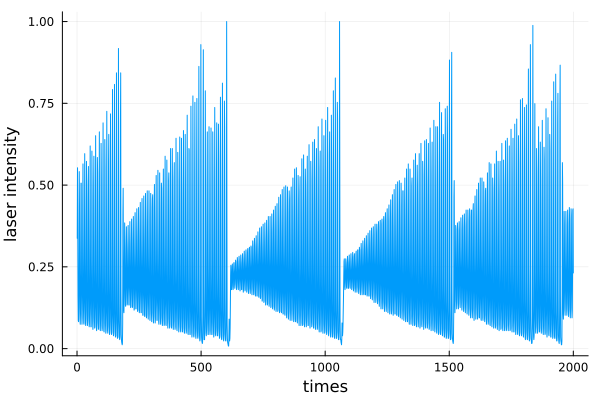

In [3]:
laser_data  = DataFrame(CSV.File("data/Laser.csv"))[!, "laser"]/255;
Plots.plot(laser_data[1:2000], label="")
xlabel!("times")
ylabel!("laser intensity")

Our task will be simple one-step prediction given a set time-window of data before the prediction point. In order to engineer our features and determine a reasonable time-window, we perform [PACF](https://online.stat.psu.edu/stat510/lesson/2/2.2) analysis.

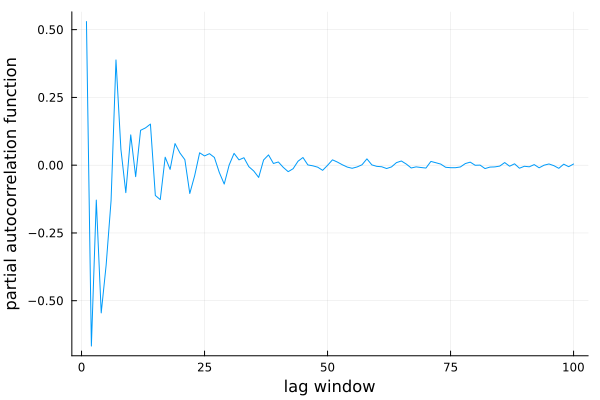

In [4]:
lnw=100
acc=pacf(laser_data, collect(1:lnw); method=:regression);
Plots.plot(collect(1:lnw), acc, label="")
xlabel!("lag window")
ylabel!("partial autocorrelation function")

Based on PACF, we determine that the window of 10 datapoints is sufficient for small scale simulations, although there should be appreciable benefits of longer windows as well. We are now ready to split our dataset into train and test, as well as engineer our features (10 step time windows), and training/test outcomes (next step timeseries values).

In [5]:
window=10;
train_data = laser_data[1:1400]
test_data=laser_data[1401:2000]
ln_train=length(train_data)
ln_test=length(test_data)
train_features=hcat([train_data[i:(i+window-1)] for i in 1:ln_train-window]...)
train_outcomes=hcat(train_data[window+1:end]...)
test_features=hcat([test_data[i:(i+window-1)] for i in 1:ln_test-window]...)
test_outcomes=hcat(test_data[window+1:end]...);

Here is how our training features and correct outcomes look:

In [6]:
train_features

10×1390 Matrix{Float64}:
 0.337255   0.552941   0.372549   …  0.145098   0.0745098  0.0666667
 0.552941   0.372549   0.160784      0.0745098  0.0666667  0.0941176
 0.372549   0.160784   0.0862745     0.0666667  0.0941176  0.239216
 0.160784   0.0862745  0.0823529     0.0941176  0.239216   0.572549
 0.0862745  0.0823529  0.12549       0.239216   0.572549   0.529412
 0.0823529  0.12549    0.282353   …  0.572549   0.529412   0.203922
 0.12549    0.282353   0.541176      0.529412   0.203922   0.0901961
 0.282353   0.541176   0.435294      0.203922   0.0901961  0.0588235
 0.541176   0.435294   0.188235      0.0901961  0.0588235  0.0745098
 0.435294   0.188235   0.0901961     0.0588235  0.0745098  0.156863

In [7]:
train_outcomes

1×1390 Matrix{Float64}:
 0.188235  0.0901961  0.0745098  0.105882  …  0.0745098  0.156863  0.435294

## Quantum simulation

We now proceed to set up the quantum simulation using [Bloqade.jl](https://queracomputing.github.io/Bloqade.jl/dev/). Many of the details are similar to the MNIST Demo, so we will only cover important changes. The most relevant new feature we introduce is the choice between two encoding methods:
- Local detuning encoding - values in the time-window feature are encoded in the different local detuning values on each atom.
- Global detuning encoding (new!) - values in the time-window feature are encoded into the time profile of the global detuning


In [8]:
# Define the DetuningLayer struct
Base.@kwdef struct DetuningLayer
    atoms # atom positions
    readouts # readout observables
    Ω::Float64 # Rabi frequency
    t_start::Float64 # evolution starting time
    t_end::Float64 # evolution ending time
    step::Float64  # window time step
    rate::Float64  # measurement rate per step
    reg::AbstractArrayReg # quantum state storage
end

DetuningLayer

In [9]:
# The function implementing local detuning encoding of the feature x, identical to the MNIST notebook.
# For more details on simulation, please refer to Bloqade.jl and Yao.jl
function apply_layer(layer::DetuningLayer, x::Vector{<:Real})
    # define Rydberg hamiltonian, detunings parameterized in terms of feature vector values (x)  
     
    
    # At the start of the simulation, all atoms of the system are in ground states
    reg = layer.reg
    set_zero_state!(reg) 
    
    t_start = layer.t_start
    t_end = layer.t_end
    t_step = layer.step
    t_rate= layer.rate
    
    # initialize output vector
    steps = floor(Int, (t_end - t_start) / t_step * t_rate)
    out = zeros(steps * length(layer.readouts))
    h = rydberg_h(layer.atoms; Δ = x, Ω = layer.Ω)
    # Numerically simulate the quantum evolution with Krylov methods and store the readouts
    i = 1
    prob =  KrylovEvolution(reg, layer.t_start:(layer.step/layer.rate):layer.t_end, h)
    for (step, reg, _) in prob # step through the state at each time step 
        step == 1 && continue # ignore first time step, this is just the initial state
        for op in layer.readouts
            out[i] = real(expect(op, reg)) # store the expectation of each operator for the given state in the output vector 
            i+=1
        end
    end
    return out
end

apply_layer (generic function with 1 method)

The next function implements global detuning encoding by encoding one time-window feature vector `x` into the piecewise-linear time profile of the global detuning pulse in the Rydberg Hamiltonian. 

In [10]:
function apply_layer_gl(layer::DetuningLayer, x::Vector{<:Real}, nshots=0)
    # define Rydberg hamiltonian, detunings parameterized in terms of feature vector values (x)  
     
    # At the start of the simulation, all atoms of the system are in ground states
    reg = layer.reg
    set_zero_state!(reg) 
    
    t_start = layer.t_start
    t_end = layer.t_end
    t_step = layer.step
    t_rate= layer.rate
    rabi_ramp=0.05
    # initialize output vector
    steps = floor(Int, (t_end - t_start) / t_step * t_rate)
    out = zeros(steps * length(layer.readouts))
    rabi = piecewise_linear(
        clocks = [0.0, rabi_ramp, layer.t_end-rabi_ramp, layer.t_end], 
        values=[0.0, layer.Ω, layer.Ω, 0.0])
    
    #piecewise linear encoding of the time-window feature vector (note, the last timepoint is repeated)
    Δpc = piecewise_linear(clocks = collect(t_start:t_step:t_end), values = push!(x,x[end])); 
    ϕ = piecewise_constant(clocks = [0, t_end] , values = [0])
    h = rydberg_h(layer.atoms; Δ = Δpc, Ω = rabi, ϕ=ϕ)
    # Numerically simulate the quantum evolution, we switch to ODE solver instead of the Krylov evolution as we no longer have time-constant pulses
    i = 1
    prob =  SchrodingerProblem(reg, layer.t_end, h, adaptive = true)
    integrator = init(prob, Vern8())
    for _ in TimeChoiceIterator(integrator, collect((t_start+t_step):t_step:t_end))
        prob.reg # state at selected time
        for op in layer.readouts
            if nshots > 0
                ex = sum(measure(op, reg; nshots)) / nshots
                out[i]=real(ex)
            else
                out[i] = real(expect(op, copy(prob.reg))) # store the expectation of each operator for the given state in the output vector
            end 
            i+=1
        end
    end
    return out
end

apply_layer_gl (generic function with 2 methods)

In [11]:
# implement functions that apply a `DetuningLayer` to a matrix containing scaled detunings for each image
# one can additionaly choose the encoding time to use
function apply_layer(layer::DetuningLayer, x::Matrix{<:Real}; time_encoding=true)
    iter = SHOW_PROGRESS_BAR ? ProgressBar(1:size(x, 2)) : 1:size(x, 2)
    if time_encoding
        outs = [apply_layer_gl(layer, x[:, i][:]) for i in iter]
    else
        outs = [apply_layer(layer, x[:, i][:]) for i in iter]
    end
    return hcat(outs...)
end

apply_layer (generic function with 2 methods)

## Training and performance

Before we proceed to evaluate QRC embeddings and test our approach, we define a function that relies [Flux.jl] in order to implement a simple linear regression layer providing an outcome prediction from generated QRC embeddings. The loss function we use is the (normalized) mean-square loss (NMSE) between the model predictions and the true timeseries outcomes, averaged over the training set. The same NMSE loss is used as a measure of test set success - the average over one-step prediction losses over the test set windows.

Note, often time-series problems involve multistep predictions. The same feature engineering, encoding and training approach can still be used, with the resulting one-step prediction model then being applied repeatedly on the test set and previous model predictions. The performance of such multistep approach is directly correlated to basic average one-step prediction performance we report.

In [12]:
function train(xs_train, ys_train, xs_test, ys_test; 
    regularization::Float64 = 0.0, nepochs::Int = 100, batchsize::Int = 100, 
    opt = Flux.Adam(0.001), verbose::Bool=false, nonlinear::Bool=false)
    
    model = Dense(length(xs_train[:, 1]), 1)

    if nonlinear #additional feature - we can compare our results to 4-layer neural network
        model = Chain(
            Dense(length(xs_train[:, 1]), 100, relu),
            Dense(100, 100, relu),
            Dense(100, 1)
        )
    end

    loader = Flux.DataLoader((data = xs_train, label = ys_train); batchsize, shuffle=true);
    ps = Flux.params(model)

    verbose && println("Training...")
    losses = zeros(nepochs)
    losses_test = zeros(nepochs)
    for epoch in (verbose ? ProgressBar(1:nepochs) : 1:nepochs)
    l = 10000.0
    for (x, y) in loader
        grads = Flux.gradient(ps) do
            ŷ = model(x)
            if iszero(regularization)
                l = Flux.mse(ŷ, y, agg=sum)/sum((y .- mean(y)).^2)
            else
                l = Flux.mse(ŷ, y, agg=sum)/sum((y .- mean(y)).^2) + regularization * sum(sum(abs, p) for p in ps)
            end
        end
        Flux.update!(opt, ps, grads)
    end
    losses[epoch] = Flux.mse(model(xs_train), ys_train, agg=sum)/sum((ys_train .- mean(ys_train)).^2)
    losses_test[epoch] = Flux.mse(model(xs_test), ys_test, agg=sum)/sum((ys_test .- mean(ys_test)).^2)
    end
    return losses, losses_test, model
end

train (generic function with 1 method)

We start by setting up a benchmark - how does the linear regression do on our data.

In [13]:
losses, losses_test, model =train(train_features, train_outcomes, test_features, test_outcomes; 
regularization = 0.000, nepochs = 3000, batchsize = 1000, 
opt = Flux.Adam(0.01), verbose=false, nonlinear=false)

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(10 => 1)      # 11 parameters
│   summary(x) = "10×1000 Matrix{Float64}"
└ @ Flux ~/.julia/packages/Flux/CUn7U/src/layers/stateless.jl:60


([1.7557675440333884, 1.5011804123334982, 1.3104398748309325, 1.1489052861030753, 0.9945837653938474, 0.8494000289015057, 0.7257786816902965, 0.6290054145935803, 0.5548104914113158, 0.4943744097637266  …  0.1901827474938364, 0.18825725033076834, 0.1884469581474132, 0.18802886021960713, 0.18799376485628871, 0.18784222669959158, 0.18785527378273004, 0.1878468721304319, 0.18788056626150007, 0.18786158978280426], [1.731584288404196, 1.49936014125983, 1.3181468783637895, 1.1630557485223674, 1.0183272553130691, 0.8849730427193242, 0.7715108644662205, 0.6812722647073916, 0.6110163821712459, 0.554315206829623  …  0.21979528969078566, 0.2187914703774312, 0.21863496472558705, 0.21801895634085353, 0.21801417169499893, 0.2179552934036282, 0.21781939150280272, 0.2173632297925283, 0.2168079813264587, 0.2162775322282451], Dense(10 => 1))

Training curve to check for overfitting.

Train NMSE linear= 0.18786158978280426
Test NMSE linear = 0.2162775322282451


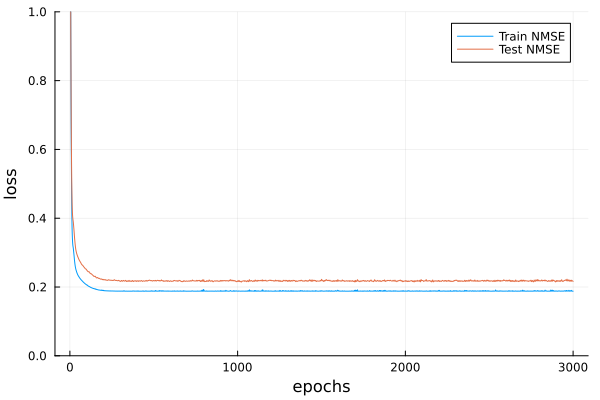

In [14]:
println("Train NMSE linear= ",losses[end])
println("Test NMSE linear = ",losses_test[end])
Plots.plot(losses, label="Train NMSE")
Plots.plot!(losses_test, label="Test NMSE")
ylims!(0.,1.0)
xlabel!("epochs")
ylabel!("loss")

Looking at the prediction on the piece of the dataset with the regime switch. The linear model struggles at the switch.

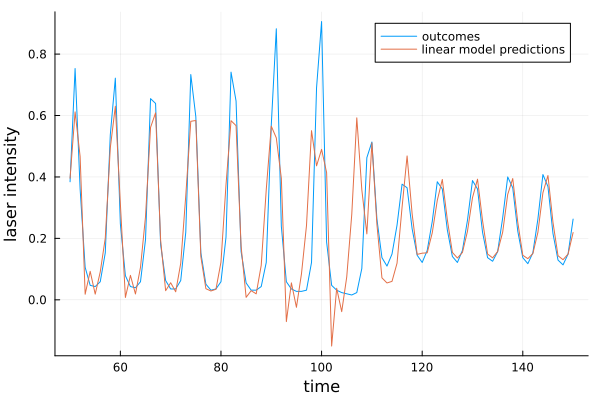

In [15]:
Plots.plot(collect(50:150),test_outcomes[50:150], label="outcomes")
Plots.plot!(collect(50:150),model(test_features)[50:150], label="linear model predictions")
xlabel!("time")
ylabel!("laser intensity")

On the opposite end 4-layer neural network shows massive improvement.

In [16]:
losses, losses_test, model =train(train_features, train_outcomes, test_features, test_outcomes; 
regularization = 0.000, nepochs = 5000, batchsize = 1000, 
opt = Flux.Adam(0.004), verbose=false, nonlinear=true)

([1.1404871682439623, 0.350914602668072, 0.48116468033572246, 0.3320526253208595, 0.34932706768519933, 0.22010288079691745, 0.2238823991215683, 0.22613782799027052, 0.18674347639631875, 0.18947493164009227  …  0.00023400679388416116, 0.00021865942198789106, 0.00023395321439896423, 0.00023345367210786714, 0.00021003232175723937, 0.00022683330759701209, 0.00024558612490763784, 0.00031405305970043314, 0.0002454333494009754, 0.0005051257613171202], [1.0853630310303208, 0.416341207298808, 0.46291202783051294, 0.38079353719784564, 0.3893229367397919, 0.2599929541494163, 0.252805468349568, 0.25722558043007676, 0.2227490061974323, 0.21315144946890568  …  0.0029870759084271044, 0.0030599690724565204, 0.003028865382943674, 0.003028632888009955, 0.002926773579785151, 0.0030191499060146015, 0.0029924944210570317, 0.0031129198054099605, 0.002947661155024355, 0.00306584943697443], Chain(Dense(10 => 100, relu), Dense(100 => 100, relu), Dense(100 => 1)))

Train NMSE NN= 0.0005051257613171202
Test NMSE NN = 0.00306584943697443


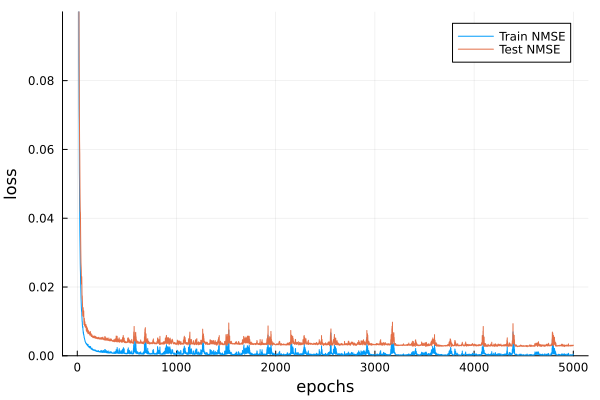

In [17]:
println("Train NMSE NN= ",losses[end])
println("Test NMSE NN = ",losses_test[end])
Plots.plot(losses, label="Train NMSE")
Plots.plot!(losses_test, label="Test NMSE")
ylims!(0.,0.1)
xlabel!("epochs")
ylabel!("loss")

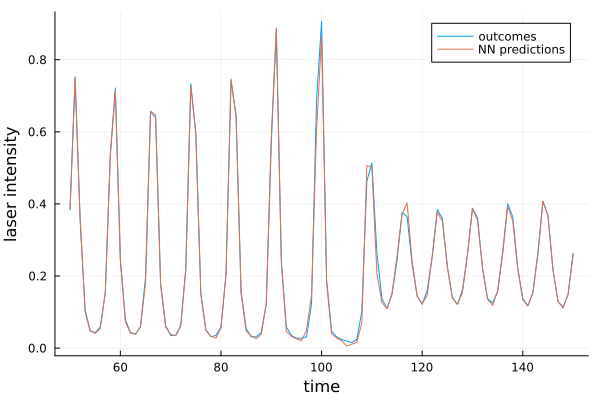

In [18]:
Plots.plot(collect(50:150),test_outcomes[50:150], label="outcomes")
Plots.plot!(collect(50:150),model(test_features)[50:150], label="NN predictions")
xlabel!("time")
ylabel!("laser intensity")

Let us turn to QRC now. We first employ local detuning encoding QRC. Note that the parameter use almost perfectly transfer from the MNIST notebook.

In [19]:
# Generate atom positions for the toy model
d = 10
nsites = 10
atoms = generate_sites(ChainLattice(), nsites; scale = d); # put atoms in a chain with 10 micron spacing
# create all single site Zᵢ and correlator ZᵢZⱼ readouts 
readouts = AbstractBlock[put(nsites, i => Z) for i in 1:nsites]
for i in 1:nsites
    for j in i+1:nsites
        push!(readouts, chain(put(nsites, i => Z), put(nsites, j => Z)))
    end
end

# build preprocessing layer 
pre_layer = DetuningLayer(;
    atoms, 
    readouts, 
    Ω = 2π, 
    t_start = 0.0, 
    t_end = 4.0, 
    step = 0.5,
    rate=1,
    reg = zero_state(nsites)
);

Δ_max = 6.0
xs = (train_features .- mean(train_features)) * Δ_max;
ys = (test_features .- mean(train_features)) * Δ_max;

In [20]:
# uncomment the next line to see progress bar
SHOW_PROGRESS_BAR = false 
embeddings = apply_layer(pre_layer, xs, time_encoding=false)
test_embeddings = apply_layer(pre_layer, ys, time_encoding=false)

440×590 Matrix{Float64}:
 -0.77139    -0.62683     -0.442604   …  -0.425791    -0.535223
 -0.0698057   0.146955     0.189721       0.0321429   -0.157434
  0.113474    0.142477     0.145848      -0.195489    -0.175782
  0.144195    0.148101     0.121506      -0.174807     0.0078536
  0.148107    0.121499    -0.0646405      0.00789375   0.105335
  0.1215     -0.064644    -0.381889   …   0.105333     0.121455
 -0.0647145  -0.381923    -0.23231        0.121435     0.106165
 -0.382508   -0.234155     0.0682281      0.104949    -0.000640097
 -0.192794    0.113885     0.183433       0.0235895   -0.167335
 -0.445212   -0.38223     -0.378598      -0.701775    -0.692414
  0.134698   -0.241223    -0.332926   …  -0.21057      0.0381121
 -0.144992    0.0470215    0.156102       0.26029      0.218073
 -0.108136   -0.136225    -0.115882       0.0391825   -0.0266944
  ⋮                                   ⋱               
 -0.161104   -0.133755     0.0471039     -0.102891    -0.204919
 -0.153301   -0.12

In [21]:
losses, losses_test, model =train(embeddings, train_outcomes, test_embeddings, test_outcomes; 
regularization = 0.0001, nepochs = 5000, batchsize = 1000, 
opt = Flux.Adam(0.004), verbose=false, nonlinear=false)

([1.9997945348807222, 2.1788620842973407, 0.5119270611466056, 0.8657809293072114, 1.067522832719992, 0.5471759530044155, 0.6365866373984118, 0.7979132217568304, 0.454578971681233, 0.2885033534136987  …  0.0018807260410368784, 0.001807514497729317, 0.0018114880859117256, 0.0017504877786279074, 0.001803344362999679, 0.0017662193253445001, 0.0017691246801671064, 0.0017458963029340748, 0.0017713190801972667, 0.0017711150354279771], [1.6971677892905017, 1.6204668874036465, 0.5329767009015199, 0.7029052941667281, 0.8189928672605608, 0.515066045607099, 0.5623943759602296, 0.6442826706855179, 0.4296241232271416, 0.32499801165273506  …  0.006135399174813398, 0.006222385704055051, 0.006166564118482008, 0.005926186721335534, 0.005907470295624963, 0.006055180665912781, 0.006066801399482063, 0.00596177883002161, 0.005960174299678774, 0.00594073742036365], Dense(440 => 1))

Train NMSE QRC= 0.0017711150354279771
Test NMSE QRC = 0.00594073742036365


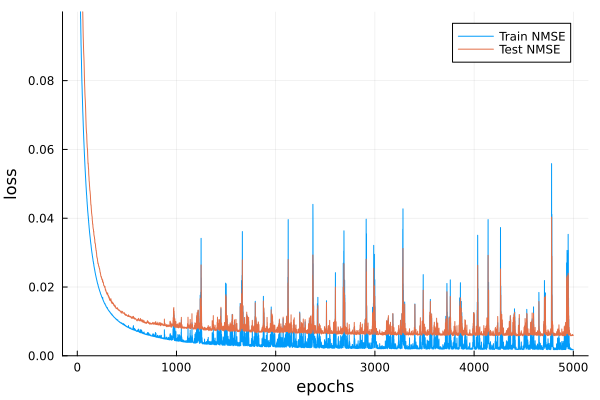

In [22]:
println("Train NMSE QRC= ",losses[end])
println("Test NMSE QRC = ",losses_test[end])
Plots.plot(losses, label="Train NMSE")
Plots.plot!(losses_test, label="Test NMSE")
ylims!(0.,0.1)
xlabel!("epochs")
ylabel!("loss")

The local detuning QRC performance is roughly on par with 4-layer neural network!

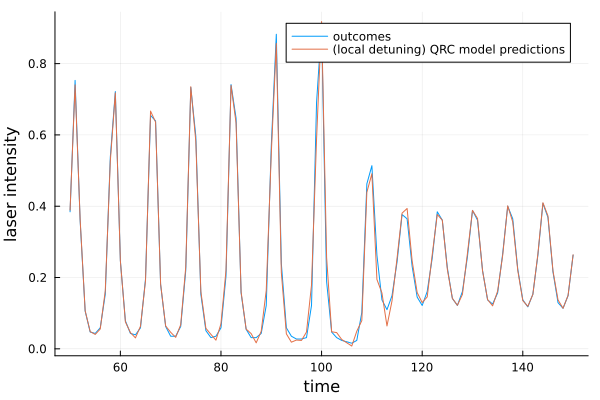

In [23]:
Plots.plot(collect(50:150),test_outcomes[50:150], label="outcomes")
Plots.plot!(collect(50:150),model(test_embeddings)[50:150], label="(local detuning) QRC model predictions")
xlabel!("time")
ylabel!("laser intensity")

Lastly, we check out the global detuning encoding. In order to break approximate translational symmetry existing at the start of the evolution, we slightly perturb atom distances from their regular values. The other parameters are also changed in order to fit 10 encoding and measurement intervals into the time evolution, thus encoding the time-window features.

In [24]:
# irregular atom distances for the toy model, distances fixed for consistency
nsites = 10
rat=[8.3, 8.2, 8.2, 8.2, 8.1, 8.8, 8.2, 8.8, 8.8]
atoms=AtomList([(0.0, sum(rat[1:i])) for i in 0:(nsites-1)])
# create all single site Zᵢ and correlator ZᵢZⱼ readouts 
readouts = AbstractBlock[put(nsites, i => Z) for i in 1:nsites]
for i in 1:nsites
    for j in i+1:nsites
        push!(readouts, chain(put(nsites, i => Z), put(nsites, j => Z)))
    end
end

# build preprocessing layer 
pre_layer = DetuningLayer(;
    atoms, 
    readouts, 
    Ω = 2π*1.5, 
    t_start = 0.0, 
    t_end = 3.5, 
    step = 3.5/window,
    rate=1,
    reg = zero_state(nsites)
);

Δ_max = 9.0
xs = (train_features .- mean(train_features)) * Δ_max;
ys = (test_features .- mean(train_features)) * Δ_max;

In [25]:
# uncomment the next line to see progress bar
SHOW_PROGRESS_BAR = false 
embeddings = apply_layer(pre_layer, xs, time_encoding=true)
test_embeddings = apply_layer(pre_layer, ys, time_encoding=true)

550×590 Matrix{Float64}:
 -0.143071    -0.114655    -0.0925695  …  -0.126679    -0.15557
  0.296227     0.416209     0.453488       0.431275     0.3793
  0.268908     0.321796     0.344009       0.326355     0.300089
  0.25608      0.317493     0.342709       0.323236     0.292689
  0.337259     0.380435     0.396589       0.384686     0.366056
  0.141596     0.23513      0.280256   …   0.243764     0.190067
  0.194221     0.282223     0.321809       0.289053     0.239677
  0.226471     0.315066     0.351462       0.321698     0.275249
  0.069743     0.247906     0.316361       0.26246      0.166641
 -0.420322    -0.273344    -0.207061      -0.282036    -0.379534
 -0.434789    -0.568595    -0.557151   …  -0.561528    -0.511986
  0.246409     0.429871     0.456145       0.430372     0.350022
 -0.204758    -0.322402    -0.328971      -0.343608    -0.308894
  ⋮                                    ⋱               
 -0.0295194    0.131297     0.131172       0.092602     0.062436
  0.0458499 

In [26]:
losses, losses_test, model =train(embeddings, train_outcomes, test_embeddings, test_outcomes; 
regularization = 0.0001, nepochs = 5000, batchsize = 1000, 
opt = Flux.Adam(0.004), verbose=false, nonlinear=false)

([1.1331306745395306, 5.245653339946094, 2.7533486820998614, 0.6445007143495838, 1.965204583746868, 2.1275257452973744, 0.7780880884389078, 0.5237484448532457, 1.1448727548854327, 0.94832688332092  …  0.014201224204342496, 0.014396799037207504, 0.014594923818718051, 0.013732999161024374, 0.01710717460227469, 0.013002159162996544, 0.0162668370764301, 0.013369849049379634, 0.0165338496578831, 0.013204845902356956], [1.1243698553226396, 3.7903958079024394, 2.107656660862197, 0.7110799254238027, 1.59655199163178, 1.6875234938546526, 0.7520256209817676, 0.541996582586625, 0.9301514099535884, 0.7975765794015974  …  0.02784276557468782, 0.02820301859294467, 0.028414382533644842, 0.027584805138052896, 0.029667482975636223, 0.02707386803191987, 0.029184985784976046, 0.027248714536399304, 0.029295304663516614, 0.02699851151975541], Dense(550 => 1))

Train NMSE QRC= 0.013204845902356956
Test NMSE QRC = 0.02699851151975541


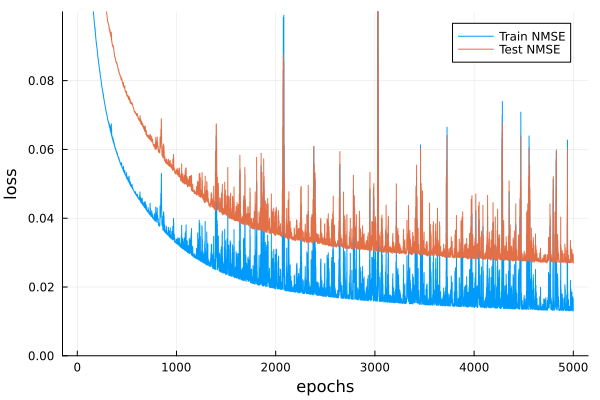

In [27]:
println("Train NMSE QRC= ",losses[end])
println("Test NMSE QRC = ",losses_test[end])
Plots.plot(losses, label="Train NMSE")
Plots.plot!(losses_test, label="Test NMSE")
ylims!(0.,0.1)
xlabel!("epochs")
ylabel!("loss")

The global detuning encoding works, however the performance is between linear and local detuning encoded QRC performance. It can, however, be further improved by increasing system size which is here independent on the encoding dimension.

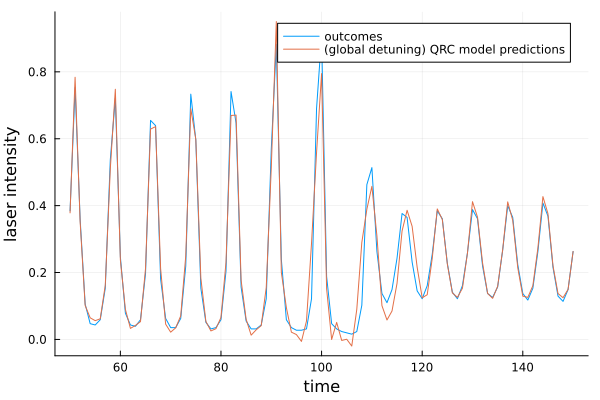

In [28]:
Plots.plot(collect(50:150),test_outcomes[50:150], label="outcomes")
Plots.plot!(collect(50:150),model(test_embeddings)[50:150], label="(global detuning) QRC model predictions")
xlabel!("time")
ylabel!("laser intensity")